# Decision Tree using Amazon Fine food reviews

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [3]:

# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

#  Preprocessing

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more g

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and"ko-"  is "child of" or of "derived from".) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.
What can I say..

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb pan bread a Portuguese loan word and quot ko quot is quot child of quot or of quot derived from quot Panko are used for katsudon tonkatsu or cutlets served on rice or in soups The cutlets pounded chicken or pork are coated with these light and crispy crumbs and fried They are not gritty and dense like regular crumbs They are very nice on deep fried shrimps and decorative for a more gourmet touch 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 160176/160176 [01:12<00:00, 2319.70it/s]


In [24]:
final['CleanedText']=preprocessed_reviews
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...,remembered book childhood got kids good rememb...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138686,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,1,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertaining rhyming story cleaver catchy illu...
138685,150503,0006641040,A3R5XMPFU8YZ4D,"Her Royal Motherliness ""Nana""",1,1,1,1233964800,so fun to read,This is my grand daughter's and my favorite bo...,grand daughter favorite book read loves rhythm...


In [25]:
data=final.sample(100000)
print("For 100000 samples :\n" , data['Score'].value_counts())

For 100000 samples :
 1    84166
0    15834
Name: Score, dtype: int64


In [26]:
#Sorting According to Time
data["Time"] = pd.to_datetime(data["Time"], unit = "s")
data = data.sort_values(by = "Time")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,2000-06-23,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
138017,149789,B00004S1C6,A1KXONFPU2XQ5K,Stephanie Manley,26,28,1,2000-08-09,A must have!,"These are easy to use, they do not make a mess...",easy use not make mess offer vibrant colors no...
138000,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,1,2000-12-05,Who Needs Wilton?,I'm sick of scads of nasty toothpicks all over...,sick scads nasty toothpicks counter tinting ic...


In [0]:
# this is for 100k points
X=data['CleanedText']
y=data['Score']

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # random splitting
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)
print('*'*100)

(44890,) (44890,)
(22110,) (22110,)
(33000,) (33000,)
****************************************************************************************************


In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from scipy.stats import uniform
from collections import Counter
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
# Importing libraries
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix,precision_score,recall_score
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
print('**'*60)

************************************************************************************************************************


## BAG OF WORDS

In [30]:
#BoW
bow = CountVectorizer().fit(X_train)
X_train_bow=bow.transform(X_train)
X_test_bow=bow.transform(X_test)
X_cv_bow=bow.transform(X_cv)
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(44890, 40356) (44890,)
(22110, 40356) (22110,)
(33000, 40356) (33000,)


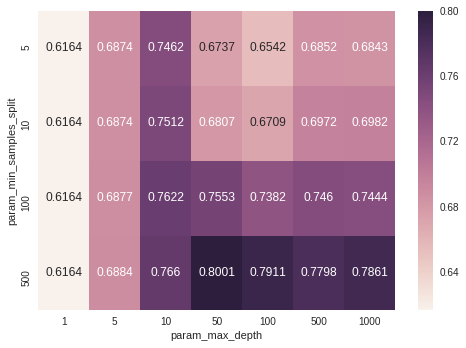

In [31]:
grid = {'max_depth':[1, 5, 10, 50, 100, 500, 1000] ,
        'min_samples_split':[5, 10, 100, 500] }
algo=DecisionTreeClassifier()

model = GridSearchCV(estimator=algo, param_grid=grid,cv=3 ,scoring = 'roc_auc')
model.fit(X_train_bow, y_train)
# and after some hours
df_gridsearch = pd.DataFrame(model.cv_results_)
max_scores = df_gridsearch.groupby(['param_min_samples_split','param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

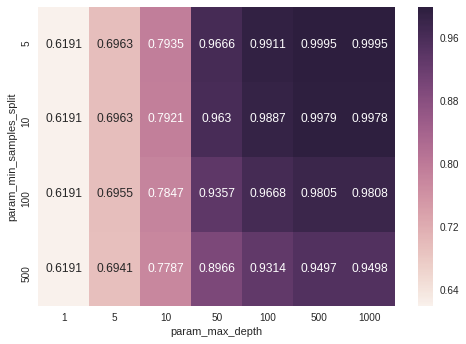

In [32]:
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g');

In [33]:
best_bow = model.best_params_
print("The best hyper parameters  is : ",best_bow)
best_param_for_depth = model.best_estimator_.max_depth
best_param_for_sample = model.best_estimator_.min_samples_split
print(best_param_for_sample)
print(best_param_for_depth)

The best hyper parameters  is :  {'max_depth': 50, 'min_samples_split': 500}
500
50


In [0]:
sample_bow = DecisionTreeClassifier(min_samples_split=best_param_for_sample,max_features=best_param_for_depth)
sample_bow.fit(X_train_bow,y_train)
predictions_sample_bow_test = sample_bow.predict_proba(X_test_bow)[:,1]
predictions_sample_bow_train = sample_bow.predict_proba(X_train_bow)[:,1]
sample_auc_bow_test=roc_auc_score(y_test, predictions_sample_bow_test)
sample_auc_bow_train=roc_auc_score(y_train, predictions_sample_bow_train)

In [35]:
print('\nThe Sample AUC test  ', sample_auc_bow_test)
print('\nThe Sample AUC train  ',sample_auc_bow_train)
print('\nThe Error test socre ',(1-sample_auc_bow_test))
print('\nThe Error train socre  ', (1-sample_auc_bow_train))


The Sample AUC test   0.7457154013717465

The Sample AUC train   0.8540029189158718

The Error test socre  0.2542845986282535

The Error train socre   0.14599708108412823


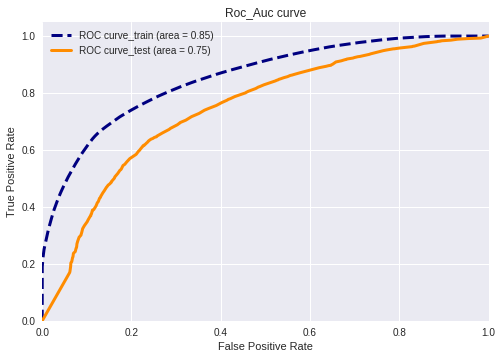

Train confusion matrix
[[ 2047  5041]
 [  846 36956]]
Test confusion matrix
[[  869  4362]
 [  980 26789]]


In [36]:
from sklearn.metrics import roc_curve, auc


### Computing ROC curve 
from sklearn import metrics
#y_sampletest_predict  =  sample_bow.predict_proba(X_test_bow)[:,1]
#y_sampletrain_predict =  sample_bow.predict_proba(X_train_bow)[:,1]
sampletrain_fpr,sampletrain_tpr,_ =  metrics.roc_curve(y_train,predictions_sample_bow_train) 
sampletest_fpr,sampletest_tpr, _ = metrics.roc_curve(y_test,predictions_sample_bow_test)

roc_auc_sampletest = auc(sampletest_fpr, sampletest_tpr) 
roc_auc_sampletrain = auc(sampletrain_fpr,sampletrain_tpr) 
### Plot
plt.figure()
lw = 3 
#plt.plot(train_fpr, train_tpr, color='navy',lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train)
plt.plot(sampletrain_fpr,sampletrain_tpr, color='navy',
         lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_sampletrain)

plt.plot(sampletest_fpr,sampletest_tpr, color='darkorange', lw=lw,label='ROC curve_test (area = %0.2f)' % roc_auc_sampletest)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
decision_samplebow_train=confusion_matrix(y_train, sample_bow.predict(X_train_bow))
print(decision_samplebow_train)
print("Test confusion matrix")
decision_samplebow_test=confusion_matrix(y_test, sample_bow.predict(X_test_bow))
print(decision_samplebow_test)

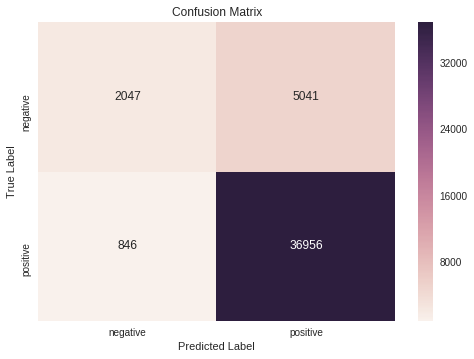

************************************************************************************************************************


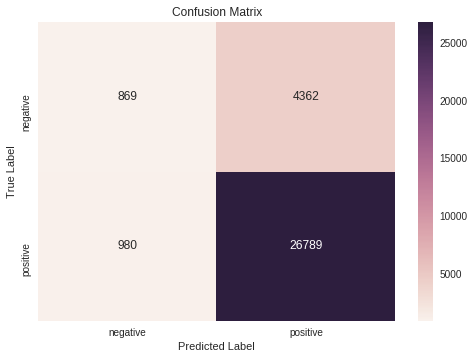

In [37]:
import seaborn as sns
class_label = ["negative", "positive"]
decision_sampletrain_heatmap = pd.DataFrame(decision_samplebow_train, index = class_label, columns = class_label)
sns.heatmap(decision_sampletrain_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('**'*60)

decision_sampletest_heatmap = pd.DataFrame(decision_samplebow_test, index = class_label, columns = class_label)
sns.heatmap(decision_sampletest_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [38]:
features_decision_bow=np.asarray(bow.get_feature_names())
features_decision_bow.shape

(40356,)

In [39]:
w_sample_bow=sample_bow.feature_importances_
weights_sample=np.transpose(w_sample_bow)
features_frame_samplebow=pd.DataFrame(data=weights_sample,index=features_decision_bow,columns=['weights'])
features_frame_sample_bow=features_frame_samplebow.sort_values(by=['weights'])
features_sample_bow_pos=(features_frame_sample_bow.loc[features_frame_sample_bow['weights']>0]) # Pos Features
features_sample_bow_neg=(features_frame_sample_bow.loc[features_frame_sample_bow['weights']<0]) #neg Features 

#****--> Note :- When i am printing above line code., it showing empty data-frame., that is there is no feature values that below 0
print(features_sample_bow_pos[0:20])
#print(features_frame_sample_bow[0:20]) # Top 20 features
#print(features_sample_bow_neg[0:10])

                 weights
dollar      3.030192e-08
stress      3.371747e-08
stupid      3.384495e-08
ole         3.936068e-08
fits        4.004281e-08
turn        4.084431e-08
cotton      4.103868e-08
kcupsin     4.173006e-08
assistance  4.183025e-08
lazy        4.338632e-08
cool        4.423801e-08
requests    5.787759e-08
forgot      5.865991e-08
softest     5.914552e-08
sitting     6.086470e-08
doesnt      6.121500e-08
lollipops   6.581249e-08
becoming    6.890786e-08
generous    6.894283e-08
outer       8.048208e-08


## Graphviz tree

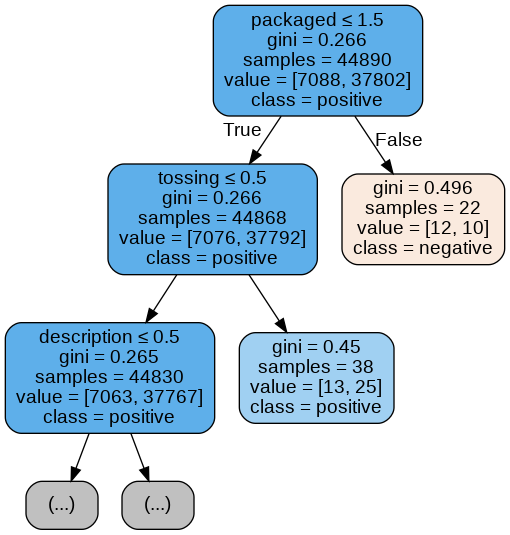

In [40]:
target = 'negative','positive'
# Create DOT data
dot_data_sample = tree.export_graphviz(sample_bow,out_file=None,class_names=target,max_depth=2,feature_names=features_decision_bow,filled=True,rounded=True,special_characters=True)
sample_graph = pydotplus.graph_from_dot_data(dot_data_sample)  
# Show graph
Image(sample_graph.create_png())

## TFIDF

In [41]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10).fit(X_train)
X_train_tfidf=tfidf_vect.transform(X_train)
X_test_tfidf=tfidf_vect.transform(X_test)
X_cv_tfidf=tfidf_vect.transform(X_cv)
print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(44890, 26390) (44890,)
(22110, 26390) (22110,)
(33000, 26390) (33000,)


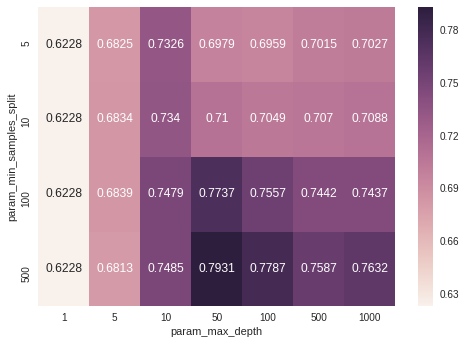

In [42]:
#grid = {'max_features':[1, 5, 10, 50, 100, 500, 1000] ,'min_samples_split':[5, 10, 100, 500] }
#algo=DecisionTreeClassifier()

model_tfidf = GridSearchCV(estimator=algo, param_grid=grid,cv=3 ,scoring = 'roc_auc')
model_tfidf.fit(X_train_tfidf, y_train)
# and after some hours
tfidf_searchframe = pd.DataFrame(model_tfidf.cv_results_)
max_scores_tfidf = tfidf_searchframe.groupby(['param_min_samples_split','param_max_depth']).max()
max_scores_tfidf = max_scores_tfidf.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores_tfidf.mean_test_score, annot=True, fmt='.4g');

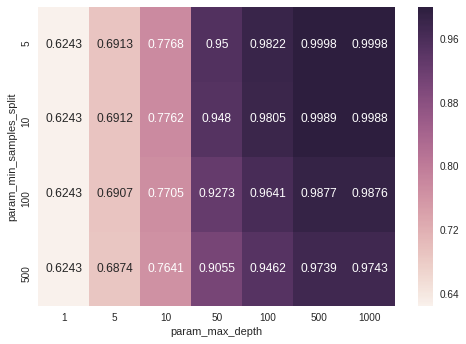

In [43]:
sns.heatmap(max_scores_tfidf.mean_train_score, annot=True, fmt='.4g');

In [44]:
best_tfidf = model_tfidf.best_params_
print("The best hyper parameters  is : ",best_tfidf)
best_param_for_depthtf = model_tfidf.best_estimator_.max_depth
best_param_for_sampletf = model_tfidf.best_estimator_.min_samples_split
print(best_param_for_sampletf)
print(best_param_for_depthtf)

The best hyper parameters  is :  {'max_depth': 50, 'min_samples_split': 500}
500
50


In [0]:
sample_tfidf = DecisionTreeClassifier(min_samples_split=best_param_for_sampletf,max_features=best_param_for_depthtf)
sample_tfidf.fit(X_train_tfidf,y_train)
predictions_sampletfidf_test = sample_tfidf.predict_proba(X_test_tfidf)[:,1]
predictions_sampletfidf_train = sample_tfidf.predict_proba(X_train_tfidf)[:,1]
auc_sampletfidf_test=roc_auc_score(y_test, predictions_sampletfidf_test)
auc_sampletfidf_train=roc_auc_score(y_train, predictions_sampletfidf_train)

In [46]:
print('\nThe Sample AUC test  ', auc_sampletfidf_test)
print('\nThe Sample AUC train  ',auc_sampletfidf_train)
print('\nThe Error test socre ',(1-auc_sampletfidf_test))
print('\nThe Error train socre  ', (1-auc_sampletfidf_train))


The Sample AUC test   0.7382852644980069

The Sample AUC train   0.9302150414127646

The Error test socre  0.2617147355019931

The Error train socre   0.06978495858723543


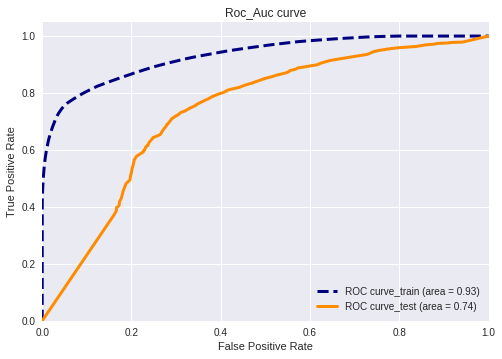

Train confusion matrix
[[ 3416  3672]
 [ 1118 36684]]
Test confusion matrix
[[ 1423  3808]
 [ 1788 25981]]


In [47]:
### Computing ROC curve 
#from sklearn import metrics
#y_test_predict_sampletfidf  = sample_tfidf.predict_proba(X_test_tfidf)[:,1]
#y_train_predict_sampletfidf =  sample_tfidf.predict_proba(X_train_tfidf)[:,1]
train_sampletfidf_fpr,train_sampletfidf_tpr,_ =  metrics.roc_curve(y_train,predictions_sampletfidf_train) 
test_sampletfidf_fpr,test_sampletfidf_tpr, _ = metrics.roc_curve(y_test,predictions_sampletfidf_test)

roc_auc_test_sampletfidf = auc(test_sampletfidf_fpr, test_sampletfidf_tpr) 
roc_auc_train_sampletfidf = auc(train_sampletfidf_fpr,train_sampletfidf_tpr) 
### Plot
plt.figure()
#lw = 3 
#plt.plot(train_fpr, train_tpr, color='navy',lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train)
plt.plot(train_sampletfidf_fpr,train_sampletfidf_tpr, color='navy',
         lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train_sampletfidf)

plt.plot(test_sampletfidf_fpr,test_sampletfidf_tpr, color='darkorange', lw=lw,label='ROC curve_test (area = %0.2f)' % roc_auc_test_sampletfidf)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

print("="*100)

#from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
sample_tfidf_train=confusion_matrix(y_train, sample_tfidf.predict(X_train_tfidf))
print(sample_tfidf_train)
print("Test confusion matrix")
sample_tfidf_test=confusion_matrix(y_test, sample_tfidf.predict(X_test_tfidf))
print(sample_tfidf_test)

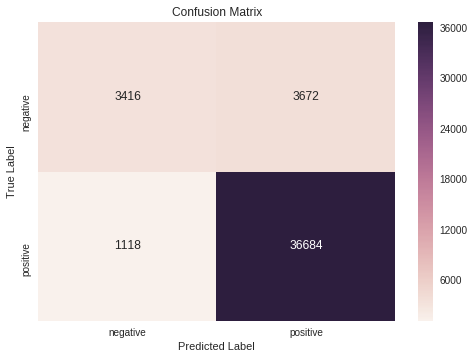

************************************************************************************************************************


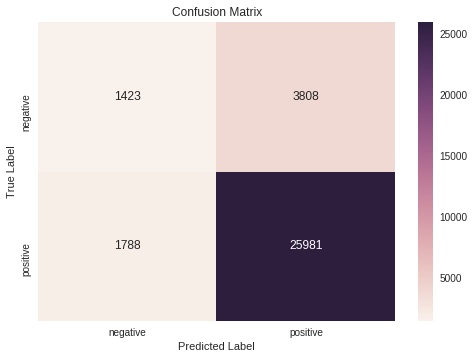

In [48]:
#import seaborn as sns
#class_label = ["negative", "positive"]
sample_train_tfidf_heatmap = pd.DataFrame(sample_tfidf_train, index = class_label, columns = class_label)
sns.heatmap(sample_train_tfidf_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('**'*60)

sample_test_tfidf_heatmap = pd.DataFrame(sample_tfidf_test, index = class_label, columns = class_label)
sns.heatmap(sample_test_tfidf_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [49]:
features_linear_tfidf=np.asarray(tfidf_vect.get_feature_names())
#features_linear_tfidf.shape
w_sample_tfidf=sample_tfidf.feature_importances_
weights_tfidf_sample=np.transpose(w_sample_tfidf)
features_frame_sampletfidf=pd.DataFrame(data=weights_tfidf_sample,index=features_linear_tfidf,columns=['weights'])
features_frame_sample_tfidf=features_frame_sampletfidf.sort_values(by=['weights'])
features_sampletfidf_pos=(features_frame_sample_tfidf.loc[features_frame_sample_tfidf['weights'] > 0]) # Pos Features
features_sampletfidf_neg=(features_frame_sample_tfidf.loc[features_frame_sample_tfidf['weights'] < 0]) 
print(features_sampletfidf_pos[0:20])
#print(features_frame_sample_tfidf[0:20])
#print(features_lineartfidf_neg[0:10])
print('#'*60)

                        weights
regular tea        2.336674e-09
offers             3.652996e-09
product glad       4.117814e-09
michigan           4.231292e-09
cocoa              5.769691e-09
special treat      6.365551e-09
aftertaste not     6.403106e-09
lemon lime         6.440994e-09
days               7.163514e-09
delighted          7.912126e-09
angeles            1.046474e-08
variety            1.072457e-08
pasta              1.424342e-08
mac cheese         1.432496e-08
tea ever           1.438184e-08
not tried          1.856547e-08
leaving            2.067289e-08
anytime            2.102327e-08
cost               2.147852e-08
product available  2.359091e-08
############################################################


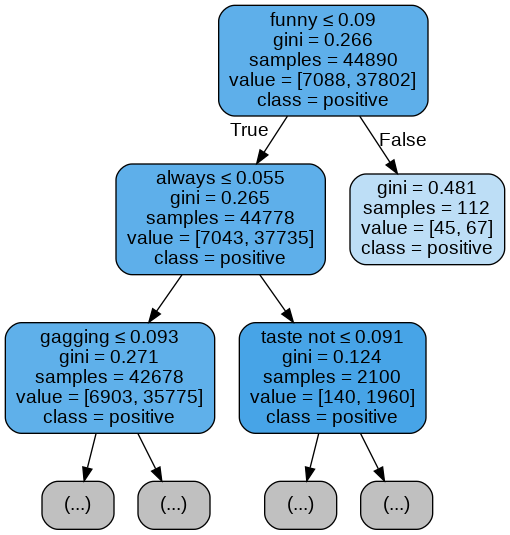

In [50]:
#target_tfidf = ['negative','positive']
# Create DOT data
dot_data_tfidf_sample = tree.export_graphviz(sample_tfidf,out_file=None,class_names=target,max_depth=2,feature_names=features_linear_tfidf,filled=True,rounded=True,special_characters=True)
graph_tfidf_sample = pydotplus.graph_from_dot_data(dot_data_tfidf_sample)  
# Show graph
Image(graph_tfidf_sample.create_png())

## W2V

In [0]:
#W2V

import re
import string
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special character
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned 
# Removing the Punctuations and HTML Tags tool

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [52]:
import gensim
i=0
sent_of_train=[]
for sentance in X_train:
    sent_of_train.append(sentance.split())
w2v_model=gensim.models.Word2Vec(sent_of_train,min_count=5,size=200, workers=4)    
print("Type of w2v_model",type(w2v_model))
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

Type of w2v_model <class 'gensim.models.word2vec.Word2Vec'>
number of words that occured minimum 5 times  12930
sample words  ['thank', 'goodness', 'brand', 'pasta', 'like', 'gluten', 'better', 'not', 'grainy', 'mushy', 'texture', 'perfect', 'easy', 'open', 'packages', 'premeasured', 'pot', 'great', 'taste', 'desert', 'mid', 'afternoon', 'would', 'continue', 'purchase', 'price', 'right', 'reviews', 'dried', 'cranberries', 'glowing', 'response', 'may', 'matter', 'found', 'little', 'bitter', 'somewhat', 'oily', 'instead', 'tang', 'usually', 'prefer', 'purchased', 'elsewhere', 'different', 'brands', 'salad', 'dressing', 'eat']


In [0]:
# List of sentence in X_test text
sent_of_test=[]
for sent1 in X_test:
    sent_of_test.append(sent1.split())   
#List of sentences in X_cv
sent_of_cv=[]
for sent2 in X_cv:
    sent_of_cv.append(sent2.split())

##  Avg W2V, TFIDF-W2V

### Avg W2v

In [0]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for senti in sent_of_train:
    sent_vec_train = np.zeros(200) 
    cnt_words_train =0; 
    for wordi in senti: # 
        if wordi in w2v_words:
            vec_train = w2v_model.wv[wordi]
            sent_vec_train += vec_train
            cnt_words_train += 1
    if cnt_words_train != 0:
        sent_vec_train /= cnt_words_train
    train_vectors.append(sent_vec_train)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sentj in sent_of_test:
    sent_vec_test = np.zeros(200) 
    cnt_words_test =0; 
    for wordj in sentj: # 
        if wordj in w2v_words:
            vec_test = w2v_model.wv[wordj]
            sent_vec_test += vec_test
            cnt_words_test += 1
    if cnt_words_test != 0:
        sent_vec_test /= cnt_words_test
    test_vectors.append(sent_vec_test) 
    
# compute average word2vec for each review for X_cv .
cv_vectors = []; 
for sentk in sent_of_cv:
    sent_vec_cv = np.zeros(200) 
    cnt_words_cv =0; 
    for wordk in sentk: # 
        if wordk in w2v_words:
            vec_cv = w2v_model.wv[wordk]
            sent_vec_cv += vec_cv
            cnt_words_cv += 1
    if cnt_words_cv != 0:
        sent_vec_cv /= cnt_words_cv
    cv_vectors.append(sent_vec_cv)
    

In [0]:
from sklearn.model_selection import GridSearchCV
values = {'max_depth':[1, 5, 10, 50, 100, 500, 1000] ,'min_samples_split':[5, 10, 100, 500] }
#algo=DecisionTreeClassifier()

model_avg = GridSearchCV(estimator=algo, param_grid=values,cv=3 ,scoring = 'roc_auc')
model_avg = model_avg.fit(train_vectors, y_train)
# and after some hours
#train_auc_avg= model_avg.cv_results_['mean_train_score']
#train_auc_avg_std= model_avg.cv_results_['std_train_score']
#cv_auc_avg = model_avg.cv_results_['mean_test_score'] 
#cv_auc_avg_std= model_avg.cv_results_['std_test_score']

avg_searchframe = pd.DataFrame(model_avg.cv_results_)
max_scores_avg = avg_searchframe.groupby(['param_min_samples_split','param_max_depth']).max()
max_scores_avg = max_scores_avg.unstack()[['mean_test_score', 'mean_train_score']]

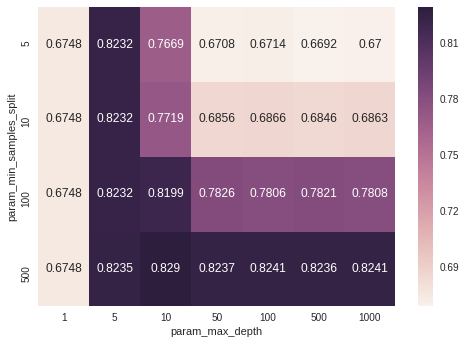

In [56]:
sns.heatmap(max_scores_avg.mean_test_score, annot=True, fmt='.4g');

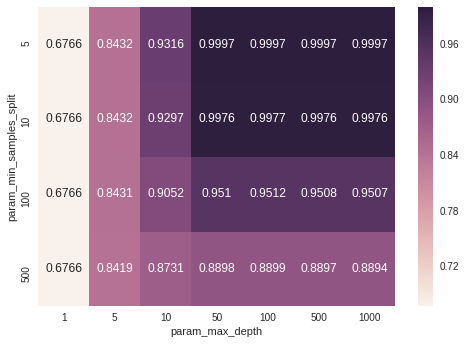

In [57]:
sns.heatmap(max_scores_avg.mean_train_score, annot=True, fmt='.4g');

In [58]:
best_avg = model_avg.best_params_
print("The best hyper parameters  is : ",best_avg)
best_param_for_depthavg = model_avg.best_estimator_.max_depth
best_param_for_sampleavg = model_avg.best_estimator_.min_samples_split
print(best_param_for_sampleavg)
print(best_param_for_depthavg)

The best hyper parameters  is :  {'max_depth': 10, 'min_samples_split': 500}
500
10


In [70]:
sample_avg = DecisionTreeClassifier(min_samples_split=best_param_for_sampleavg,max_features=best_param_for_depthavg)
sample_avg = sample_avg.fit(train_vectors, y_train)
predictions_sampleavg_test = sample_avg.predict_proba(test_vectors)[:,1]
predictions_sampleavg_train = sample_avg.predict_proba(train_vectors)[:,1]
auc_sampleavg_test=roc_auc_score(y_test, predictions_sampleavg_test)
auc_sampleavg_train=roc_auc_score(y_train, predictions_sampleavg_train)
print('\nThe AUC test score', auc_sampleavg_test)
print('\nThe AUC train score', auc_sampleavg_train)
print('\nThe AUC Test Error score', (1-auc_sampleavg_test))
print('\nThe AUC Train Error score', (1-auc_sampleavg_train))


The AUC test score 0.8030203214259675

The AUC train score 0.8477339766560776

The AUC Test Error score 0.19697967857403254

The AUC Train Error score 0.15226602334392236


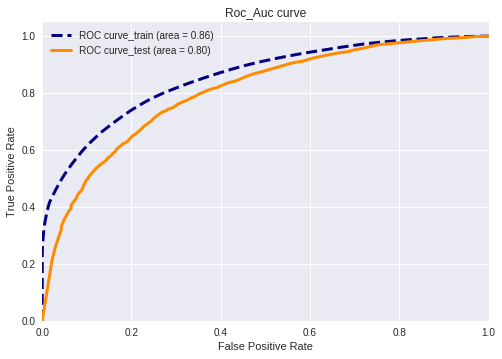

Train confusion matrix
[[ 2011  5077]
 [ 1084 36718]]
Test confusion matrix
[[ 1345  3886]
 [  940 26829]]


In [60]:
### Computing ROC curve 
#from sklearn import metrics
#y_test_predict_sampleavg  = sample_avg.predict_proba(test_vectors)[:,1]
#y_train_predict_sampleavg =  sample_avg.predict_proba(train_vectors)[:,1]
train_sampleavg_fpr,train_sampleavg_tpr,_ =  metrics.roc_curve(y_train,predictions_sampleavg_train) 
test_sampleavg_fpr,test_sampleavg_tpr, _ = metrics.roc_curve(y_test,predictions_sampleavg_test)

roc_auc_test_sampleavg = auc(test_sampleavg_fpr, test_sampleavg_tpr) 
roc_auc_train_sampleavg = auc(train_sampleavg_fpr,train_sampleavg_tpr) 
### Plot
plt.figure()
#lw = 3 
#plt.plot(train_fpr, train_tpr, color='navy',lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train)
plt.plot(train_sampleavg_fpr,train_sampleavg_tpr, color='navy',
         lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train_sampleavg)

plt.plot(test_sampleavg_fpr,test_sampleavg_tpr, color='darkorange', lw=lw,label='ROC curve_test (area = %0.2f)' % roc_auc_test_sampleavg)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

print("="*100)

#from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
sample_avg_train=confusion_matrix(y_train, sample_avg.predict(train_vectors))
print(sample_avg_train)
print("Test confusion matrix")
sample_avg_test=confusion_matrix(y_test, sample_avg.predict(test_vectors))
print(sample_avg_test)

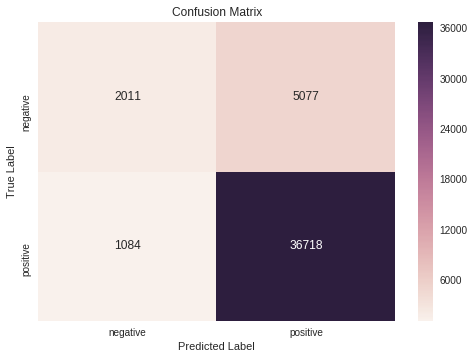

************************************************************************************************************************


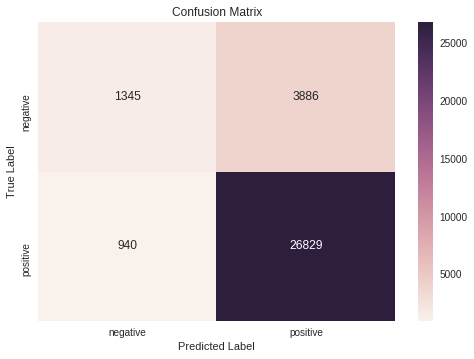

In [61]:
#import seaborn as sns
#class_label = ["negative", "positive"]
sample_train_avg_heatmap = pd.DataFrame(sample_avg_train, index = class_label, columns = class_label)
sns.heatmap(sample_train_avg_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('**'*60)

sample_test_avg_heatmap = pd.DataFrame(sample_avg_test, index = class_label, columns = class_label)
sns.heatmap(sample_test_avg_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## TFIDF W2V

In [0]:
# TF-IDF weighted Word2Vec
tfidf_vectorizer = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tfidf_train = tfidf_vectorizer.fit_transform(X_train)
final_tfidf_test = tfidf_vectorizer.transform(X_test)
final_tfidf_cv = tfidf_vectorizer.transform(X_cv)
dictionary = dict(zip(tfidf_vectorizer.get_feature_names(), list(tfidf_vectorizer.idf_)))

# tfidf words/col-names
tfidf_featuress = tfidf_vectorizer.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for senttrain in sent_of_train: 
    sent_vec_trains = np.zeros(200) 
    weight_sum_trains =0; 
    for word_trains in senttrain: 
        if word_trains in w2v_words and word_trains in tfidf_featuress:
            vec_1 = w2v_model.wv[word_trains]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_train = final_tfidf_train[row, tfidf_features.index(word_train)]
            tfidf_train = dictionary[word_trains]*(senttrain.count(word_trains)/len(senttrain))
            sent_vec_trains += (vec_1 * tfidf_train)
            weight_sum_trains += tfidf_train
    if weight_sum_trains != 0:
        sent_vec_trains /= weight_sum_trains
    tfidf_train_vectors.append(sent_vec_trains)
    row += 1

In [63]:
# compute TFIDF Weighted Word2Vec for each review for X_cv .
tfidf_cv_vectors = []; 
#row=0;
for sentcv in tqdm(sent_of_cv): 
    sent_vec_cvs = np.zeros(200) 
    weight_sum_cvs =0; 
    for word_cv in sentcv: 
        if word_cv in w2v_words and word_cv in tfidf_featuress:
            vec_2 = w2v_model.wv[word_cv]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_cv = final_tfidf_cv[row, tfidf_features.index(word)]
            tfidf_cv = dictionary[word_cv]*(sentcv.count(word_cv)/len(sentcv))
            sent_vec_cvs += (vec_2 * tfidf_cv)
            weight_sum_cvs += tfidf_cv
    if weight_sum_cvs != 0:
        sent_vec_cvs /= weight_sum_cvs
    tfidf_cv_vectors.append(sent_vec_cvs)
    row += 1

100%|██████████| 22110/22110 [07:35<00:00, 50.29it/s]


In [64]:
# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
#row=0;
for senttest in tqdm(sent_of_test): 
    sent_vec_tests = np.zeros(200) 
    weight_sum_tests =0; 
    for word_test in senttest: 
        if word_test in w2v_words and word_test in tfidf_featuress:
            vec_3 = w2v_model.wv[word_test]
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf_test = final_tfidf_test[row, tfidf_features.index(word)]
            tfidf_test = dictionary[word_test]*(senttest.count(word_test)/len(senttest))
            sent_vec_tests += (vec_3 * tfidf_test)
            weight_sum_tests += tfidf_test
    if weight_sum_tests != 0:
        sent_vec_tests /= weight_sum_tests
    tfidf_test_vectors.append(sent_vec_tests)
    row += 1

100%|██████████| 33000/33000 [11:27<00:00, 48.03it/s]


In [0]:
#from sklearn.model_selection import GridSearchCV
#values = {'max_depth':[1, 5, 10, 50, 100, 500, 1000] ,'min_samples_split':[5, 10, 100, 500] }
#algo=DecisionTreeClassifier()

model_w2v = GridSearchCV(estimator=algo, param_grid=values,cv=3 ,scoring = 'roc_auc')
model_w2v = model_w2v.fit(tfidf_train_vectors, y_train)

w2v_searchframe = pd.DataFrame(model_w2v.cv_results_)
max_scores_w2v = w2v_searchframe.groupby(['param_min_samples_split','param_max_depth']).max()
max_scores_w2v = max_scores_w2v.unstack()[['mean_test_score', 'mean_train_score']]

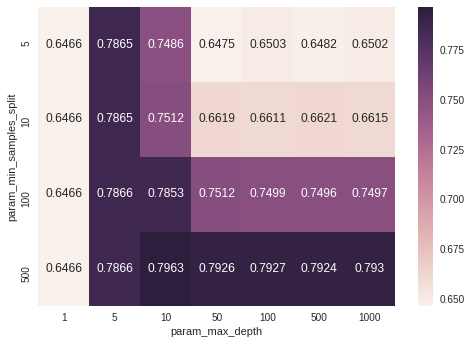

In [66]:
sns.heatmap(max_scores_w2v.mean_test_score, annot=True, fmt='.4g');

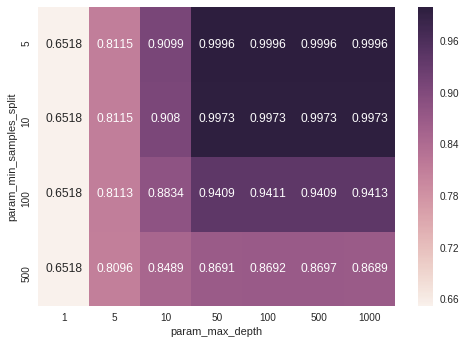

In [67]:
sns.heatmap(max_scores_w2v.mean_train_score, annot=True, fmt='.4g');

In [68]:
best_w2v = model_w2v.best_params_
print("The best hyper parameters  is : ",best_w2v)
best_param_for_depthw2v = model_w2v.best_estimator_.max_depth
best_param_for_samplew2v = model_w2v.best_estimator_.min_samples_split
print(best_param_for_samplew2v)
print(best_param_for_depthw2v)

The best hyper parameters  is :  {'max_depth': 10, 'min_samples_split': 500}
500
10


In [72]:
sample_w2v = DecisionTreeClassifier(min_samples_split=best_param_for_samplew2v,max_features=best_param_for_depthw2v)
sample_w2v.fit(tfidf_train_vectors,y_train)
predictions_samplew2v_test = sample_w2v.predict_proba(tfidf_test_vectors)[:,1]
predictions_samplew2v_train = sample_w2v.predict_proba(tfidf_train_vectors)[:,1]
auc_samplew2v_test=roc_auc_score(y_test, predictions_samplew2v_test)
auc_samplew2v_train=roc_auc_score(y_train, predictions_samplew2v_train)
print('\nThe AUC test score', auc_samplew2v_test)
print('\nThe AUC train score', auc_samplew2v_train)
print('\nThe AUC Test Error score', (1-auc_samplew2v_test))
print('\nThe AUC Train Error score', (1-auc_samplew2v_train))


The AUC test score 0.7663851863214393

The AUC train score 0.8239457860238384

The AUC Test Error score 0.23361481367856074

The AUC Train Error score 0.1760542139761616


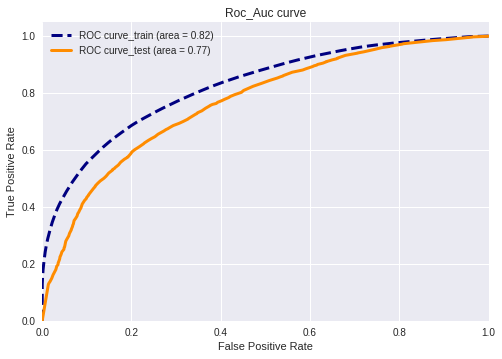

Train confusion matrix
[[ 1795  5293]
 [ 1191 36611]]
Test confusion matrix
[[ 1174  4057]
 [ 1033 26736]]


In [74]:
### Computing ROC curve 
#from sklearn import metrics
#y_test_predict_samplew2v  = sample_w2v.predict_proba(tfidf_test_vectors)[:,1]
#y_train_predict_samplew2v =  sample_w2v.predict_proba(tfidf_train_vectors)[:,1]
train_samplew2v_fpr,train_samplew2v_tpr,_ =  metrics.roc_curve(y_train,predictions_samplew2v_train) 
test_samplew2v_fpr,test_samplew2v_tpr, _ = metrics.roc_curve(y_test,predictions_samplew2v_test)

roc_auc_test_samplew2v = auc(test_samplew2v_fpr, test_samplew2v_tpr) 
roc_auc_train_samplew2v = auc(train_samplew2v_fpr,train_samplew2v_tpr) 
### Plot
plt.figure()
#lw = 3 
#plt.plot(train_fpr, train_tpr, color='navy',lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train)
plt.plot(train_samplew2v_fpr,train_samplew2v_tpr, color='navy',
         lw=lw, linestyle='--', label='ROC curve_train (area = %0.2f)' % roc_auc_train_samplew2v)

plt.plot(test_samplew2v_fpr,test_samplew2v_tpr, color='darkorange', lw=lw,label='ROC curve_test (area = %0.2f)' % roc_auc_test_samplew2v)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

print("="*100)

#from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
sample_w2v_train=confusion_matrix(y_train, sample_w2v.predict(tfidf_train_vectors))
print(sample_w2v_train)
print("Test confusion matrix")
sample_w2v_test=confusion_matrix(y_test, sample_w2v.predict(tfidf_test_vectors))
print(sample_w2v_test)

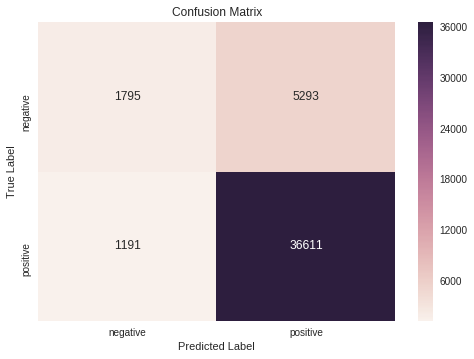

************************************************************************************************************************


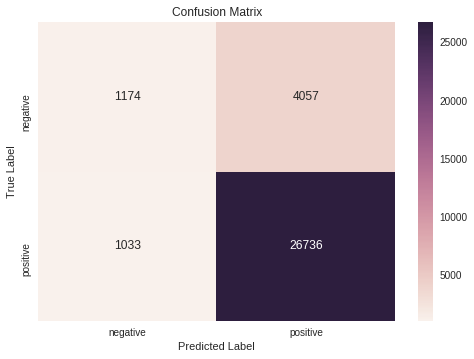

In [75]:
#import seaborn as sns
#class_label = ["negative", "positive"]
sample_train_w2v_heatmap = pd.DataFrame(sample_w2v_train, index = class_label, columns = class_label)
sns.heatmap(sample_train_w2v_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('**'*60)

sample_test_w2v_heatmap = pd.DataFrame(sample_w2v_test, index = class_label, columns = class_label)
sns.heatmap(sample_test_w2v_heatmap, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [76]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of the models
names =['Decision_Tree for BoW','Decision_Tree for TFIDF','Decision_Tree for Avg_Word2Vec', 'Decision_Tree for tfidf_Word2Vec']

# Values of optimal depth
optimal_depth = [best_param_for_depth,best_param_for_depthtf,best_param_for_depthavg,best_param_for_depthw2v]

# Values of optimal_sample_split
optimal_sample = [best_param_for_sample,best_param_for_sampletf,best_param_for_sampleavg,best_param_for_samplew2v]

# Train Accuracies of Min_sample_split
train_acc = [sample_auc_bow_train,auc_sampletfidf_train,auc_sampleavg_train,auc_samplew2v_train] 

#Test Accuracies of Min_sample_split
test_acc = [sample_auc_bow_test,auc_sampletfidf_test,auc_sampleavg_test,auc_samplew2v_test]

numbering = [1,2,3,4]

# Initializing prettytable

ptable = PrettyTable()
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Optimal Depth",optimal_depth)
ptable.add_column("Optimal Sample_split",optimal_sample)
ptable.add_column("Training Accuracy of Depth",train_acc)
ptable.add_column("Test Accuracy of Depth",test_acc)
# Printing the Table
print(ptable)


+-------+----------------------------------+---------------+----------------------+----------------------------+------------------------+
| S.NO. |              MODEL               | Optimal Depth | Optimal Sample_split | Training Accuracy of Depth | Test Accuracy of Depth |
+-------+----------------------------------+---------------+----------------------+----------------------------+------------------------+
|   1   |      Decision_Tree for BoW       |       50      |         500          |     0.8540029189158718     |   0.7457154013717465   |
|   2   |     Decision_Tree for TFIDF      |       50      |         500          |     0.9302150414127646     |   0.7382852644980069   |
|   3   |  Decision_Tree for Avg_Word2Vec  |       10      |         500          |     0.8477339766560776     |   0.8030203214259675   |
|   4   | Decision_Tree for tfidf_Word2Vec |       10      |         500          |     0.8239457860238384     |   0.7663851863214393   |
+-------+-------------------------